# Image Classification With Transfer Learning Using Keras

# Task 1: Importing Libraries

In [1]:
import tensorflow as tf
import tarfile
import urllib
import os
import numpy as np
import pets

from matplotlib import pyplot as plt
%matplotlib inline

data_dir = 'data/'
if not os.path.isdir(data_dir):
    os.mkdir(data_dir)

print('TensorFlow version:', tf.__version__)
print('Is using GPU?', tf.test.is_gpu_available())

TensorFlow version: 2.0.1
Is using GPU? False


# Task 2: Cats vs Dogs Dataset

In [2]:
pets.download_and_extract('data', '.')

In [3]:
class_to_index = {'cat': 0, 'dog': 1}
index_to_class = {0: 'cat', 1: 'dog'}

## get train and test annotation - which is dict with filename as key, and label as value.
train_annot, count_train = pets.cats_vs_dogs_annotations('data/annotations/trainval.txt')
test_annot, count_test = pets.cats_vs_dogs_annotations('data/annotations/test.txt')

print('Training examples: ', count_train)
print('Test examples: ', count_test)

Training examples:  3680
Test examples:  3669


# Task 3: Get Random Batch

In [9]:
image_dir = 'data/images/'

def random_batch(annot:dict, batch_size=4):
    all_keys = list(annot.keys()) ## all file names in the dict.
    total_ezample = len(all_keys)
    
    indices = np.random.choice(range(total_ezample), size=batch_size, replace=False)
    
    x = np.zeros((batch_size, 128, 128, 3)) ## 128x128x3 is dimention of the each image.
    y = np.zeros((batch_size, 1))
    images = []
    
    for i, index in enumerate(indices):
        image_path = os.path.join(image_dir, all_keys[index])
        image = tf.keras.preprocessing.image.load_img(image_path, target_size=(128, 128))
        
        arr = tf.keras.preprocessing.image.img_to_array(image)
        arr = tf.keras.applications.mobilenet_v2.preprocess_input(arr)
        arr = np.expand_dims(arr, axis=0) ## add dimention before 128x128x3 image size
        x[i] = arr
        y[i] =  class_to_index[ annot[all_keys[index]] ]
        
        images.append(image)
        
    return x, y, images
        
        

Displaying first 8 examples..


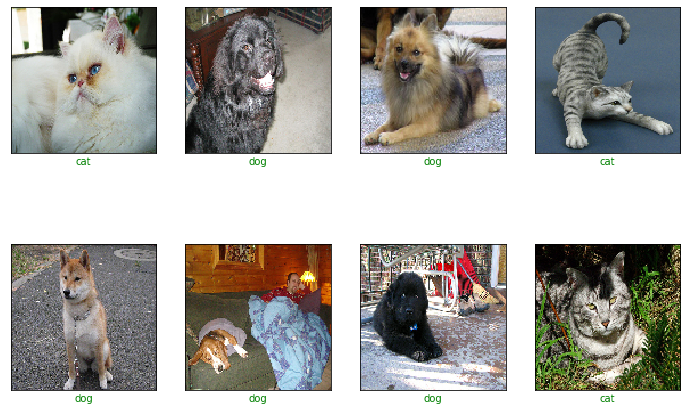

In [10]:
x, y , images = random_batch(train_annot, batch_size=8)
pets.display_examples(x, y, y, images, index_to_class).show()

# Task 4: Create Model

In [11]:
mnet = tf.keras.applications.mobilenet_v2.MobileNetV2(include_top=False,
                                                      pooling='avg',
                                                      weights='imagenet',
                                                      input_shape=(128, 128, 3)
                                                    )

mnet.summary()

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 129, 129, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [14]:
def create_model():
    
    model = tf.keras.models.Sequential([
        mnet,
        tf.keras.layers.Dropout(rate=0.5),
        tf.keras.layers.Dense(units=1, activation='sigmoid')
    ])
    
    # don't train mnet layers
    model.layers[0].trainable = False
    
    # compile model
    model.compile(loss = 'binary_crossentropy',
                  optimizer = 'adam',
                  metrics = ['accuracy']
                 )
    
    return model

In [15]:
model = create_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_128 (Model) (None, 1280)              2257984   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


# Task 5: Model Training

In [17]:
def data_generator(batch_size, annot:dict):
    
    while True:
        x, y, _ = random_batch(annot, batch_size)
        yield x, y

In [16]:
batch_size = 32
steps_per_epoch = int(count_train/batch_size)
validation_steps = int(count_test/batch_size)

print('Training steps: ', steps_per_epoch)
print('Validation steps ', validation_steps)

Training steps:  115
Validation steps  114


In [18]:
%%time

_ = model.fit_generator(data_generator(batch_size, train_annot),
                        validation_data = data_generator(batch_size, test_annot),
                        steps_per_epoch = steps_per_epoch,
                        validation_steps = validation_steps,
                        epochs = 1
                       )

115/115 [==============================] - 1051s 9s/step - loss: 0.4285 - accuracy: 0.8035 - val_loss: 0.1477 - val_accuracy: 0.9646
Wall time: 17min 31s


# Task 6: Predictions

In [24]:
x, y, images = random_batch(test_annot,  batch_size=8)
pred = model.predict(x)

Displaying first 8 examples..


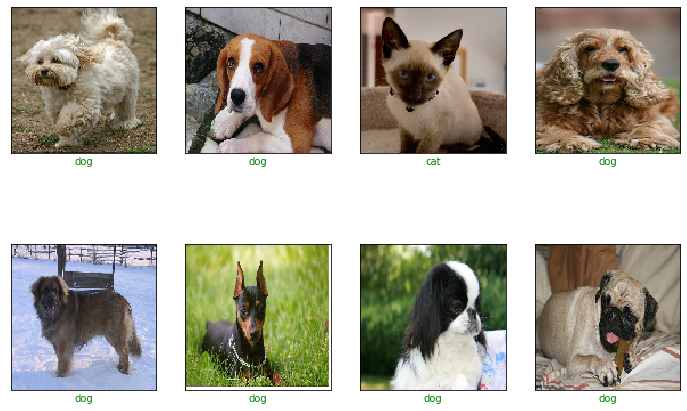

In [25]:
pets.display_examples(x, y, pred, images, index_to_class).show()